# Chapter 6: よく使うアルゴリズムとその使用例

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
np.random.seed(24)

## 6.1 HMC法

6.1.4 一変数のHMC法

In [4]:
n_iter = 10**5 # サンプル数
n_tau = 40 # リープフロッグのステップ数
d_tau = 1 # リープフロッグのステップ幅

# ボックス・ミューラー法によるガウス乱数の生成
def box_muller():
    # r, s ~ Uniform(0, 1)
    r, s = np.random.rand(), np.random.rand()

    # p, q ~ N(0, 1)
    p = np.sqrt(-2*np.log(r))*np.sin(2*np.pi*s)
    q = np.sqrt(-2*np.log(r))*np.cos(2*np.pi*s)

    return p, q

# 作用S(x)の計算
def  calc_action(x):
    action = 1/2*(x**2)
    return action

# ハミルトニアンH(x, p)の計算
def calc_hamiltonian(x, p):
    # 作用(ポテンシャルエネルギー)の計算
    s = calc_action(x)
    # 運動エネルギーを加えて、ハミルトニアンを計算する
    h = s + (1/2)*(p**2)
    return h

# ハミルトニアンのx微分、dH/dxの計算
def calc_delh(x):
    # S(x)' = (1/2*x^2)' = x
    delh = x
    return delh

# リープフロッグ(分子軌道法)による時間発展
def molucular_dynamics(x):
    r1, _ = box_muller()

    # 運動量pをガウス分布に従う乱数として生成
    p = r1

    # ハミルトニアンの計算
    ham_init = calc_hamiltonian(x, p)
    
    # リープフロッグの1ステップ目
    x = x + p*(1/2)*d_tau
    
    # リープフロッグの2, ..., n_tauステップ目
    for step  in range(1, n_tau):
        delh = calc_delh(x)
        p = p - delh*d_tau
        x = x + p*d_tau
    
    # リープフロッグの最終ステップ
    delh = calc_delh(x)
    p = p - delh*d_tau
    x = x + p*(1/2)*d_tau

    # ハミルトニアンの計算
    ham_fin = calc_hamiltonian(x, p)    

    return x, ham_init, ham_fin

def main():
    # 初期配位
    x = 0

    # 更新回数
    n_accept = 0
    # x^2の和
    sum_xx = 0
    
    xs = [x]
    for i in range(n_iter):
        backup_x = x

        # リープフロッグ
        x, ham_init, ham_fin = molucular_dynamics(x)
        
        # メトロポリステスト
        metropolis = np.random.rand()
        if np.exp(ham_init-ham_fin) > metropolis:
            # 受理
            n_accept+= 1
        else:
            # 棄却
            x = backup_x

        xs.append(x)

        # データ出力
        sum_xx += x**2
        
        # print('{} {} {}'.format(x, sum_xx/(i+1), n_accept/(i+1)))
    return xs
xs = main()

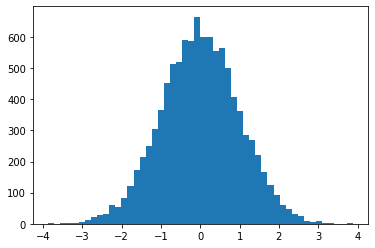

In [5]:
def select_per_n(xs, n):
    return [ xs[i] for i in range(len(xs)) if i % n == 0]
xs = select_per_n(xs, 10)
plt.hist(xs, bins=50);

6.1.5 多変数のHMC

In [6]:
n_iter = 10**5 # サンプル数
n_tau = 20 # リープフロッグのステップ数
d_tau = 1/2 # リープフロッグのステップ幅
n_dim = 3 # 変数の個数

# ボックス・ミューラー法によるガウス乱数の生成
def box_muller():
    # r, s ~ Uniform(0, 1)
    r, s = np.random.rand(), np.random.rand()

    # p, q ~ N(0, 1)
    p = np.sqrt(-2*np.log(r))*np.sin(2*np.pi*s)
    q = np.sqrt(-2*np.log(r))*np.cos(2*np.pi*s)

    return p, q

# 作用S(x)の計算
def  calc_action(x, A):
    action = 0
    for i in range(n_dim):
        for j in range(n_dim):
            action += x[i]*A[i][j]*x[j]
        action += 1/2 * x[i] * A[i][i] * x[i]
    return action

# ハミルトニアンH(x, p)の計算
def calc_hamiltonian(x, A, p):
    # 作用(ポテンシャルエネルギー)の計算
    h = calc_action(x, A)
    # 運動エネルギーを加えて、ハミルトニアンを計算する
    for i in range(n_dim):
        h = h + (1/2)*(p[i]**2)
    return h

# ハミルトニアンのx微分、dH/dxの計算
def calc_delh(x, A):
    delh = np.zeros(n_dim)
    
    for i in range(n_dim):
        for j in range(n_dim):
            delh[i] = delh[i] + A[i][j]*x[j]

    return delh

# リープフロッグ(分子軌道法)による時間発展
def molucular_dynamics(x, A):
    # 運動量pをガウス分布に従う乱数として生成
    p = []
    for i in range(n_dim):    
        r1, _ = box_muller()
        p.append(r1)
    p = np.array(p)

    # ハミルトニアンの計算
    ham_init = calc_hamiltonian(x, A, p)
    
    # リープフロッグの1ステップ目
    x = x + p * (1/2) * d_tau
    
    # リープフロッグの2, ..., n_tauステップ目
    for step  in range(1, n_tau):
        delh = calc_delh(x, A)
        p = p - delh * d_tau
        x = x + p * d_tau

    # リープフロッグの最後のステップ
    delh = calc_delh(x, A)
    p = p - delh * d_tau
    x = x + p *(1/2)* d_tau
    
    # ハミルトニアンの計算
    ham_fin = calc_hamiltonian(x, A, p)    

    return x, ham_init, ham_fin

def main():
    # 初期配位
    x = np.zeros(n_dim)
    A = np.zeros((n_dim, n_dim))

    A[0][0], A[1][1], A[2][2] = 1, 2, 2
    A[0][1], A[0][2], A[1][2] = 1, 1, 1

    A[1][0] = A[0][1]
    A[2][0] = A[0][2]
    A[2][1] = A[1][2]
    

    # 更新回数
    n_accept = 0
    
    xs = [x]
    for i in range(n_iter):
        backup_x = np.copy(x)

        # リープフロッグ
        x, ham_init, ham_fin = molucular_dynamics(x, A)
        
        # メトロポリステスト
        metropolis = np.random.rand()
        if np.exp(ham_init-ham_fin) > metropolis:
            # 受理
            n_accept+= 1
        else:
            # 棄却
            x = backup_x

        xs.append(x)

    return xs
xs = main()

In [7]:
def select_per_n(xs, n):
    return [ xs[i] for i in range(len(xs)) if i % n == 0]
xs = select_per_n(xs, 10)

In [8]:
x_0 = np.array(xs)[:, 0]
x_1 = np.array(xs)[:, 1]
x_2 = np.array(xs)[:, 2]

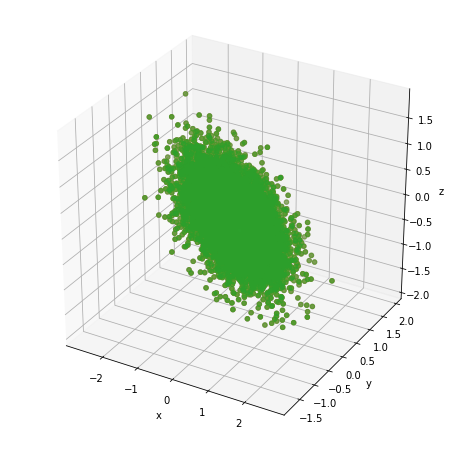

In [9]:
fig = plt.figure(figsize=(8, 8), facecolor="w")
ax = fig.add_subplot(111, projection="3d")
for c in range(3):
    ax.scatter(
        x_0,
        x_1,
        x_2
    )

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show();

## 6.2 ギブスサンプリング(熱浴法)

6.2.3 実際のシュミレーションの例

In [91]:
n_iter = 10**5 # サンプル数

# ボックス・ミューラー法によるガウス乱数の生成
def box_muller():
    # r, s ~ Uniform(0, 1)
    r, s = np.random.rand(), np.random.rand()

    # p, q ~ N(0, 1)
    p = np.sqrt(-2*np.log(r))*np.sin(2*np.pi*s)
    q = np.sqrt(-2*np.log(r))*np.cos(2*np.pi*s)

    return p, q

def main():
    A = np.zeros((n_dim, n_dim))

    A[0][0], A[1][1], A[2][2] = 1, 2, 2
    A[0][1], A[0][2], A[1][2] = 1, 1, 1
    A[1][0] = A[0][1]
    A[2][0] = A[0][2]
    A[2][1] = A[1][2]

    # 初期値の設定
    x, y, z =0, 0, 0
    xs, ys, zs = [x], [y], [z]

    for i in range(n_iter):
        # xの更新
        sigma = 1/np.sqrt(A[0][0])
        mu = -A[0][1]/A[0][0]*y - A[0][2]/A[0][0]*z
        r1, _ = box_muller()
        x = sigma*r1+mu

        # yの更新
        sigma = 1/np.sqrt(A[1][1])
        mu = -A[1][0]/A[1][1]*x - A[1][2]/A[1][1]*z
        r1, _ = box_muller()
        y = sigma*r1+mu

        # zの更新
        sigma = 1/np.sqrt(A[2][2])
        mu = -A[2][0]/A[2][2]*x - A[2][1]/A[2][2]*y
        r1, _ = box_muller()
        z = sigma*r1+mu
        
        xs.append(x)
        ys.append(y)
        zs.append(z)

    return xs, ys, zs
xs, ys, zs = main()

In [92]:
def select_per_n(xs, n):
    return [ xs[i] for i in range(len(xs)) if i % n == 0]
xs = select_per_n(xs, 10)
ys = select_per_n(ys, 10)
zs = select_per_n(zs, 10)

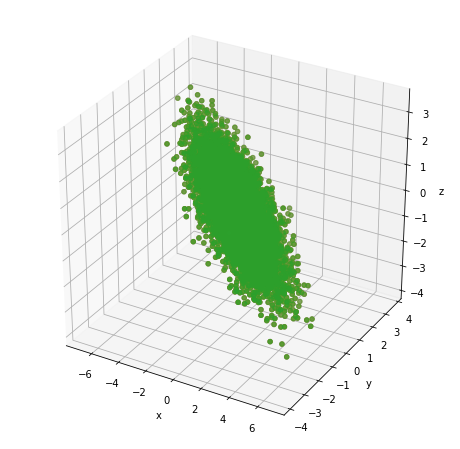

In [93]:
fig = plt.figure(figsize=(8, 8), facecolor="w")
ax = fig.add_subplot(111, projection="3d")
for c in range(3):
    ax.scatter(
        xs,
        ys,
        zs
    )

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show();